# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/oeftiger/cern/git/PyHEADTAIL/PyHEADTAIL/')

# PyHEADTAIL imports

In [3]:
from PyHEADTAIL.particles.generators import RFBucketMatcher, StationaryExponential
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.11.3





In [180]:
rfb = RFBucket(100*2*np.pi, 2.5, m_p, e, [0.027], 0., [8], [24e3], [np.pi])

sigma_z = 140e-9*0.91*c/4.

# Helper Functions

In [181]:
def plot(stat_dist_class=StationaryExponential, rfb=rfb, sigma_z=sigma_z, H0=None):
    '''Plot properties of stationary distribution class stat_dist_class
    for the given RF bucket and the bunch length (used for the guessed
    distribution Hamiltonian limit H0).
    Args:
        - stat_dist_class: Stationary Distribution class
          (e.g. generators.StationaryExponential)
        - rfb: RFBucket instance
        - sigma_z: bunch length to be matched
    '''
    try:
        stat_exp = stat_dist_class(lambda *args: rfb.hamiltonian(*args, make_convex=True))
    except TypeError:
        stat_exp = stat_dist_class
        
    if H0:
        stat_exp.H0 = H0
    else:
        stat_exp.H0 = rfb.guess_H0(sigma_z, from_variable='sigma')

    dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
    zz = np.linspace(*rfb.interval, num=1000)
    Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    plt.sca(ax[0, 0])
    plt.title('phase space distribution', fontsize=20)
    plt.contourf(Z, DP, stat_exp.function(Z, DP), 20, cmap=cm.hot_r)
    plt.colorbar().set_label(r'$\psi(z, \delta)$', fontsize=20)
    plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
    plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\delta$', fontsize=20)

    plt.sca(ax[0, 1])
    plt.title('Hamiltonian contours', fontsize=20)
    plt.contourf(Z, DP, stat_exp.H(Z, DP), 20, cmap=cm.coolwarm)
    plt.colorbar().set_label(r'$\mathcal{H}(z,\delta)$', fontsize=20)
    plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
    plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\delta$', fontsize=20)

    plt.sca(ax[1, 0])
    plt.title('line density', fontsize=20)
    plt.plot(zz, np.sum(stat_exp.function(Z, DP), axis=0), antialiased=False)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\lambda(z) = \int\; d\delta \; \psi(z, \delta)$', fontsize=20)

    plt.sca(ax[1, 1])
    plt.title('Hamiltonian distribution', fontsize=20)
    hhs = stat_exp.H(Z, DP).ravel()
    counts = stat_exp.function(Z, DP).ravel()
    perm = np.argsort(hhs)
    plt.plot(hhs[perm], counts[perm])
    plt.xlabel(r'$\mathcal{H}$', fontsize=20)
    plt.ylabel(r'$\psi(\mathcal{H})$', fontsize=20)
    plt.ylim(-0.1, 1.1)

    plt.tight_layout()
    
    return fig

In [188]:
from scipy.optimize import newton, brentq

class NewRFBucketMatcher(RFBucketMatcher):
    '''Uses brentq for exact matching as well as H0 for the input
    instead of the estimated bunch length. This approach is more
    direct than guessing a thermal H0 initial value first.
    '''
    def psi_for_emittance_newton_method(self, epsn_z):
        pass
    def psi_for_bunchlength_newton_method(self, sigma):
        # Maximum bunch length
        self.psi_object.H0 = self.rfbucket.guess_H0(
            self.rfbucket.circumference, from_variable='sigma')
        sigma_max = self._compute_sigma(self.rfbucket, self.psi)
        if sigma > sigma_max:
            self.warns('Given RMS bunch length does not fit into bucket. ' +
                       'Using (maximum) full bucket RMS bunch length ' +
                       str(sigma_max*0.99) + 'm instead.')
            sigma = sigma_max*0.99
        self.prints('*** Maximum RMS bunch length ' + str(sigma_max) + 'm.')

        def get_zc_for_sigma(H0):
            '''Width for bunch length'''
            self.psi_object.H0 = H0
            length = self._compute_sigma(self.rfbucket, self.psi)

            if np.isnan(length): raise ValueError

            self.prints('... distance to target bunch length: ' +
                        '{:.4e}'.format(length-sigma))

            return length-sigma

#         H0_init = self.rfbucket.guess_H0(
#             sigma, from_variable='sigma')
#         H0_fin = newton(get_zc_for_sigma, H0_init)
        H0_fin = brentq(get_zc_for_sigma, 1, 1e4)

        self.psi_object.H0 = H0_fin
        sigma = self._compute_sigma(self.rfbucket, self.psi)
        self.prints('--> Bunch length: ' + str(sigma))
        emittance = self._compute_emittance(self.rfbucket, self.psi)
        self.prints('--> Emittance: ' + str(emittance))

# Thermal (Gaussian-like) Distribution 

In [182]:
class StationaryExponential(object):
    def __init__(self, H, Hmax=None, Hcut=0):
        self.H = H
        self.H0 = 1
        if not Hmax:
            self.Hmax = H(0, 0)
        else:
            self.Hmax = Hmax
        self.Hcut = Hcut

    def _psi(self, H):
        # convert from convex Hamiltonian
        # (SFP being the maximum and the separatrix having zero value)
        # to conventional scale (zero-valued minimum at SFP)
        Hsep = self.Hcut + self.Hmax
        Hn = Hsep - H
        # f(Hn) - f(Hsep)
        return np.exp(-Hn / self.H0) - np.exp(-Hsep / self.H0)

    def function(self, z, dp):
        return self._psi(self.H(z, dp).clip(min=0)) / self._psi(self.Hmax)

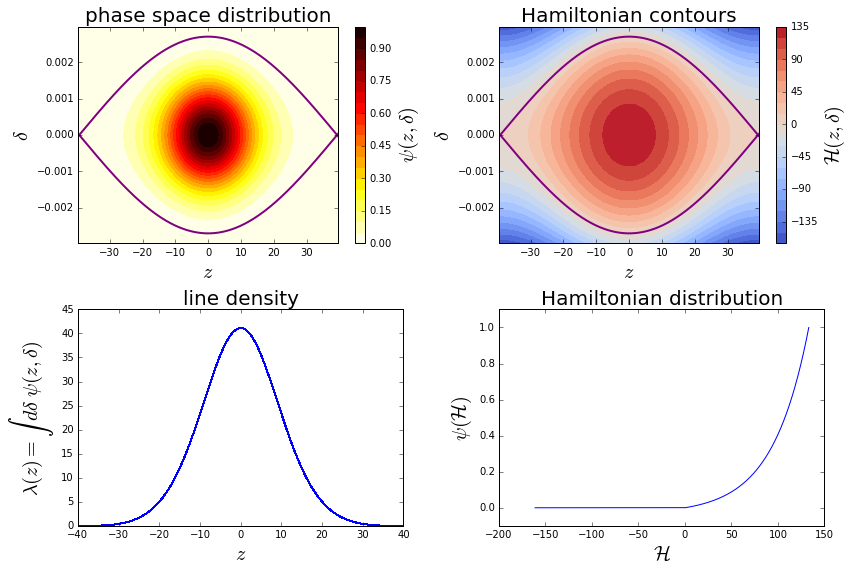

In [183]:
plot(StationaryExponential);

In [189]:
rfb_matcher = NewRFBucketMatcher(rfb, StationaryExponential, sigma_z=sigma_z)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 12.3783736062m.
... distance to target bunch length: -8.0106e+00
... distance to target bunch length: 2.8219e+00
... distance to target bunch length: 2.8188e+00
... distance to target bunch length: 2.8072e+00
... distance to target bunch length: 2.7837e+00
... distance to target bunch length: 2.7365e+00
... distance to target bunch length: 2.6407e+00
... distance to target bunch length: 2.4439e+00
... distance to target bunch length: 2.0315e+00
... distance to target bunch length: 1.1524e+00
... distance to target bunch length: -6.1217e-01
... distance to target bunch length: 2.7748e-01
... distance to target bunch length: 4.7286e-02
... distance to target bunch length: -8.2418e-04
... distance to target bunch length: 1.2296e-05
... distance to target bunch length: 3.1435e-09
... distance to target bunch length: -1.7764e-15
... distance to target bunch length: 8.3489e-14
--> Bunch length: 9.5483897873
--> Emittance: 0.764069519747


In [190]:
rfb_matcher_thermal = rfb_matcher
rfb_matcher.psi_object.H0

36.19321591648433

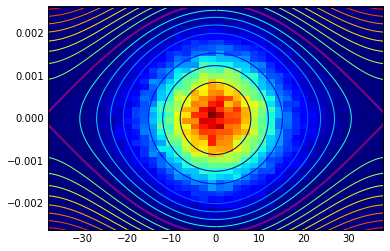

In [191]:
dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
zz = np.linspace(*rfb.interval, num=1000)
Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))
H = rfb.hamiltonian(Z, DP)
plt.contour(Z, DP, H, 20)
# plt.scatter(z, dp, alpha=0.6)
plt.hist2d(z, dp, bins=40)
plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)

# q-Gaussian Distribution

In [192]:
class StationaryQGaussian(object):
    n = 2
    def __init__(self, H, Hmax=None, Hcut=0):
        self.H = H
        self.H0 = 1
        if not Hmax:
            self.Hmax = H(0, 0)
        else:
            self.Hmax = Hmax
        self.Hcut = Hcut

    def _psi(self, H):
        # convert from convex Hamiltonian
        # (SFP being the maximum and the separatrix having zero value)
        # to conventional scale (zero-valued minimum at SFP)
        Hsep = self.Hcut + self.Hmax
        Hn = Hsep - H
        return (1 - Hn / self.H0).clip(min=0)**self.n

    def function(self, z, dp):
        return self._psi(self.H(z, dp).clip(min=0)).clip(min=0) / self._psi(self.Hmax)

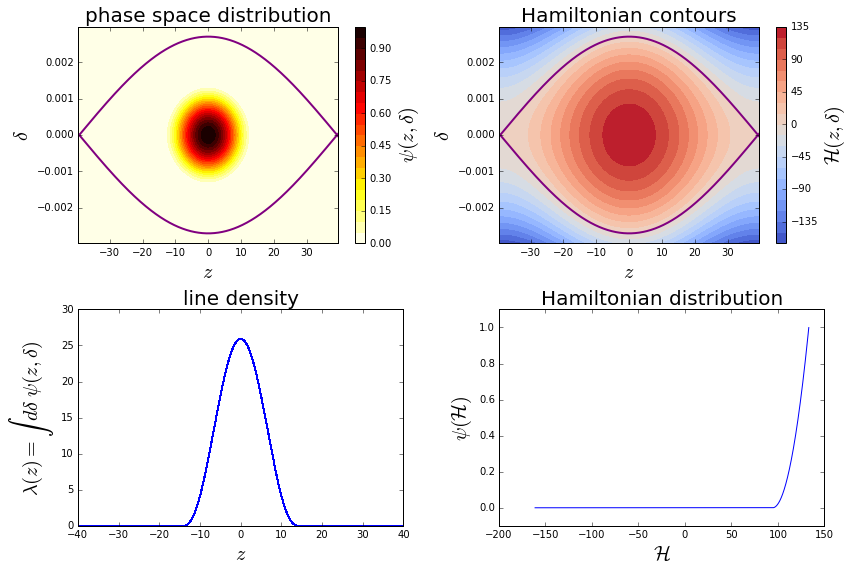

In [193]:
plot(StationaryQGaussian);

In [226]:
# rfb_matcher = RFBucketMatcher(rfb, StationaryQGaussian, sigma_z=sigma_z)
rfb_matcher = NewRFBucketMatcher(rfb, StationaryQGaussian, sigma_z=sigma_z)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 17.0888244326m.
... distance to target bunch length: -8.7819e+00
... distance to target bunch length: 7.4948e+00
... distance to target bunch length: 7.4527e+00
... distance to target bunch length: 7.3592e+00
... distance to target bunch length: 7.1628e+00
... distance to target bunch length: 6.7292e+00
... distance to target bunch length: 5.6677e+00
... distance to target bunch length: 2.5710e+00
... distance to target bunch length: -1.9363e+00
... distance to target bunch length: -3.3909e-02
... distance to target bunch length: 4.2932e-04
... distance to target bunch length: -6.9778e-07
... distance to target bunch length: -3.2846e-10
... distance to target bunch length: 0.0000e+00
--> Bunch length: 9.5483897873
--> Emittance: 0.779629528215


In [195]:
rfb_matcher.psi_object.H0

122.13560674326664

This `H0` value is 4 times larger than the counterpart of the matched thermal distribution above!

In [196]:
rfb_matcher.psi_object.Hmax

133.16302101979701

In [197]:
rfb_matcher._compute_sigma(rfb, rfb_matcher.psi)

9.5483897873000014

In [198]:
rfb_matcher.psi(rfb.z_left, 0)

0.0

The $\psi$ value at the separatrix has to be 0 otherwise there will be particles spawned outside the separatrix meaning that the bunch length does not fit into the bucket. Currently, the maximum bunch length still provides an `H0` corresponding to a thermal distribution which is why the matcher does not complain -- this will have to be generalised.

$\implies$ the matched distribution with the correct `H0` to produce the sought $\sigma_z$:

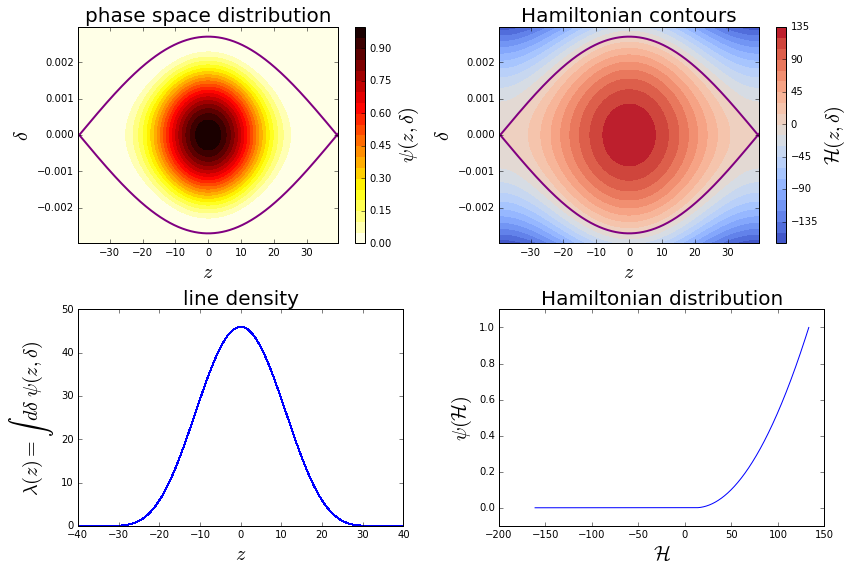

In [200]:
plot(rfb_matcher.psi_object, H0=122.13560674326664);

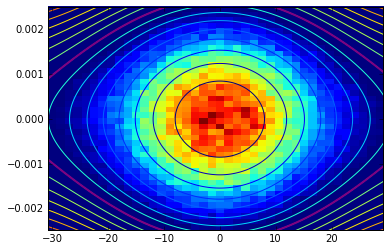

In [201]:
dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
zz = np.linspace(*rfb.interval, num=1000)
Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))
H = rfb.hamiltonian(Z, DP)
plt.contour(Z, DP, H, 20)
# plt.scatter(z, dp, alpha=0.6)
plt.hist2d(z, dp, bins=40)
plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)

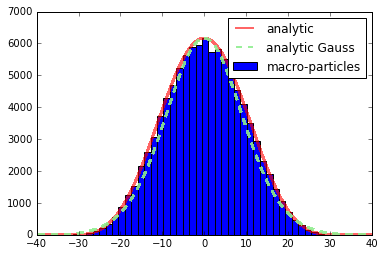

In [239]:
analytical_res = np.sum(rfb_matcher.psi_object.function(Z, DP), axis=0)
analytical_res_thermal = np.sum(rfb_matcher_thermal.psi_object.function(Z, DP), axis=0)
n, _, _ = plt.hist(z, bins=40, label='macro-particles')
plt.plot(zz, analytical_res * n.max() / analytical_res.max(), 
         antialiased=False, color='red', alpha=0.6, lw=2, 
         label='analytic')
plt.plot(zz, analytical_res_thermal * n.max() / analytical_res_thermal.max(), 
         antialiased=False, color='lightgreen', alpha=0.9, lw=2, ls='--',
         label='analytic Gauss')
plt.legend(loc=0);

# Parabolic Bunch Shape

In [209]:
class StationaryParabolic(object):
    def __init__(self, H, Hmax=None, Hcut=0):
        self.H = H
        self.H0 = 1
        if not Hmax:
            self.Hmax = H(0, 0)
        else:
            self.Hmax = Hmax
        self.Hcut = Hcut

    def _psi(self, H):
        # convert from convex Hamiltonian
        # (SFP being the maximum and the separatrix having zero value)
        # to conventional scale (zero-valued minimum at SFP)
        Hsep = self.Hcut + self.Hmax
        Hn = Hsep - H
        return np.sqrt((1 - Hn / self.H0).clip(min=0))

    def function(self, z, dp):
        psi = self._psi(self.H(z, dp).clip(min=0))
#         return psi
        return psi / self._psi(self.Hmax)

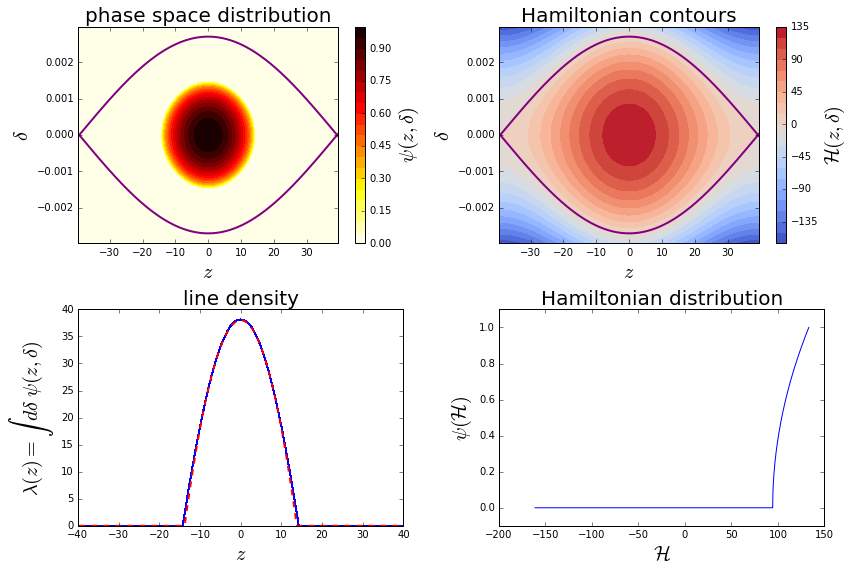

In [214]:
fig = plot(StationaryParabolic);
plt.sca(fig.axes[2])
# plt.plot(zz, (49 - 0.15*zz**2).clip(min=0), color='red', lw=2, ls='--');
plt.plot(zz, (38 - 0.2*zz**2).clip(min=0), color='red', lw=2, ls='--');

In [215]:
### takes ages because of super slow moment integration!
rfb_matcher = RFBucketMatcher(rfb, StationaryParabolic, sigma_z=sigma_z)

z, dp, _, _ = rfb_matcher.generate(int(1e5))

*** Maximum RMS bunch length 17.0909697093m.
... distance to target bunch length: -3.2534e+00
... distance to target bunch length: -3.2527e+00
... distance to target bunch length: 3.3960e-01
... distance to target bunch length: -4.0800e-02
... distance to target bunch length: -5.8208e-04
... distance to target bunch length: 1.5977e-06
... distance to target bunch length: 1.3026e-08
... distance to target bunch length: -7.4996e-11
--> Bunch length: 9.5483897873
--> Emittance: 0.792784700436


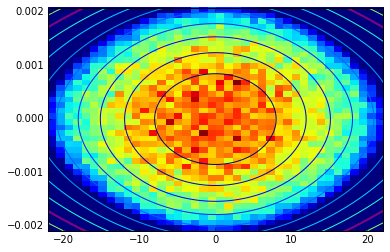

In [216]:
dpmax = rfb.dp_max(rfb.z_ufp_separatrix)
zz = np.linspace(*rfb.interval, num=1000)
Z, DP = np.meshgrid(zz, np.linspace(-dpmax*1.1, dpmax*1.1, num=100))
H = rfb.hamiltonian(Z, DP)
plt.contour(Z, DP, H, 20)
# plt.scatter(z, dp, alpha=0.6)
plt.hist2d(z, dp, bins=40)
plt.plot(zz, rfb.separatrix(zz), c='purple', lw=2)
plt.plot(zz, -rfb.separatrix(zz), c='purple', lw=2)

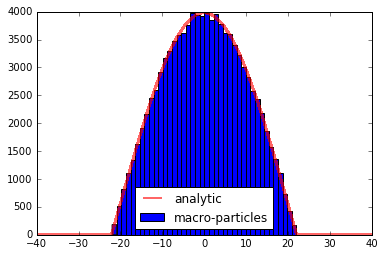

In [225]:
analytical_res = np.sum(rfb_matcher.psi_object.function(Z, DP), axis=0)
n, _, _ = plt.hist(z, bins=40, label='macro-particles')
plt.plot(zz, analytical_res * n.max() / analytical_res.max(), 
         antialiased=False, color='red', alpha=0.6, lw=2, 
         label='analytic')
plt.legend(loc=0);

# Waterbag

In [203]:
class StationaryWaterbag(object):
    def __init__(self, H, Hmax=None, Hcut=0):
        self.H = H
        self.H0 = 1
        if not Hmax:
            self.Hmax = H(0, 0)
        else:
            self.Hmax = Hmax
        self.Hcut = Hcut

    def _psi(self, H):
        # convert from convex Hamiltonian
        # (SFP being the maximum and the separatrix having zero value)
        # to conventional scale (zero-valued minimum at SFP)
        Hsep = self.Hcut + self.Hmax
        Hn = Hsep - H
        return np.piecewise(Hn, [Hn <= self.H0, Hn > self.H0], [1./self.H0, 0])

    def function(self, z, dp):
        return self._psi(self.H(z, dp).clip(min=0)) / self._psi(self.Hmax)

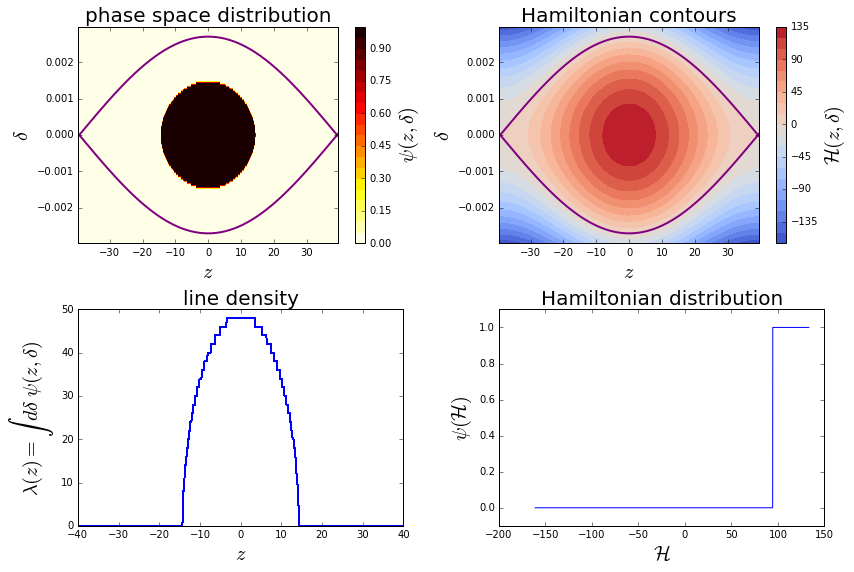

In [204]:
plot(StationaryWaterbag);

Longer bunches also work nicely, observe the fitting to the deformed Hamiltonian lines close to the unstable fix points:

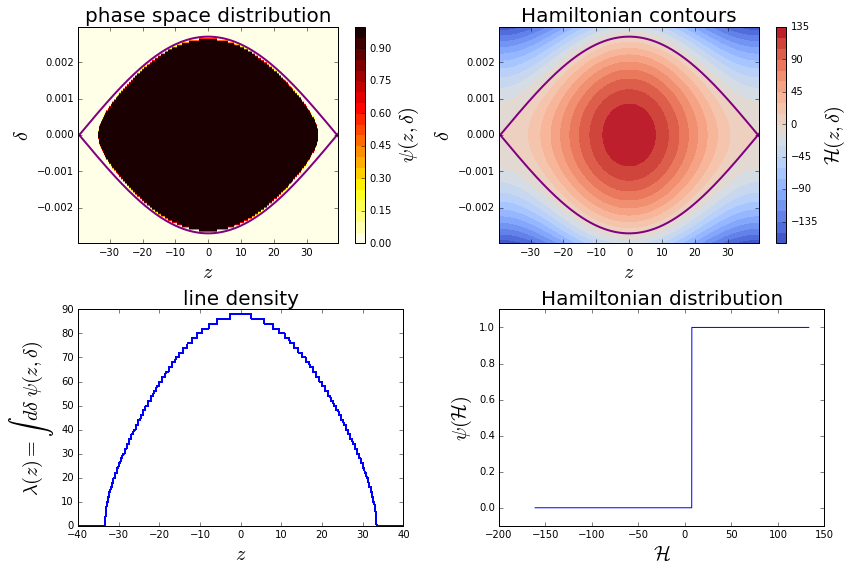

In [206]:
plot(StationaryWaterbag, sigma_z = 1.8*sigma_z);

In [207]:
# rfb_matcher = RFBucketMatcher(rfb, StationaryWaterbag, sigma_z=sigma_z)
rfb_matcher = NewRFBucketMatcher(rfb, StationaryWaterbag, sigma_z=sigma_z)

In [ ]:
### ===> runs too long! problematic!
rfb_matcher._compute_sigma(rfb, rfb_matcher.psi_object)

In [ ]:
### ===> since moment integration takes too long, the optimisation is not doable in time!
rfb_matcher.psi_for_variable(rfb_matcher.variable)

In [ ]:
### ===> if the above time problems are solved, this should work:
z, dp, _, _ = rfb_matcher.generate(int(1e5), cutting_margin=1e-15)